In [35]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [36]:
!pip install kaggle

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle.json': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
! kaggle datasets download -d cihan063/autism-image-data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip autism-image-data.zip

unzip:  cannot find or open autism-image-data.zip, autism-image-data.zip.zip or autism-image-data.zip.ZIP.


In [37]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import random
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import optimizers , layers, applications
Adam=tf.keras.optimizers.Adam()

In [38]:

train_data = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [39]:
train_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/train")
categories = []
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': categories
})

In [40]:
train_df.head()

,filename,category
0,Non_Autistic.1239.jpg,0
1,Non_Autistic.1173.jpg,0
2,Non_Autistic.1172.jpg,0
3,Non_Autistic.1167.jpg,0
4,Non_Autistic.1171.jpg,0


In [41]:
test_data = ImageDataGenerator(rescale=1./255)

In [42]:
test_filenames = os.listdir("/content/drive/MyDrive/AutismDataset/test")
categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

In [43]:
test_df.head()

,filename,category
0,Autistic.105.jpg,1
1,Autistic.130.jpg,1
2,Autistic.115.jpg,1
3,Autistic.135.jpg,1
4,Autistic.101.jpg,1


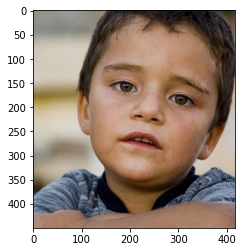

In [44]:
sample = random.choice(train_filenames)
image = load_img("/content/drive/MyDrive/AutismDataset/train/"+sample)
plt.imshow(image)

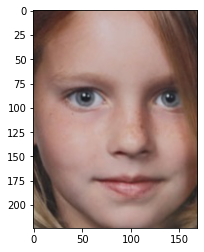

In [ ]:
sample_test = random.choice(test_filenames)
image= load_img("/content/drive/MyDrive/AutismDataset/test/"+sample_test)
plt.imshow(image)

**VGG-19 MODEL**

In [58]:
image_size = 224
input_shape = (image_size, image_size,3)

#Hyperparameters
epochs = 30
batch_size = 32

pre_trained_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers:
    layer.trainable = False

# Flatten the output layer to 1 dimension
x = keras.models.Sequential()
x.add(pre_trained_model)
x.add(layers.Flatten())
# Add a fully connected layer with 128 hidden units and ReLU activation
x.add(layers.Dense(512, activation='relu'))
# Add a dropout rate of 0.5
x.add(layers.Dropout(0.5))
# Add a fully connected layer with 64 hidden units and ReLU activation
#x.add(layers.Dense(64, activation='relu'))
# Add a final sigmoid layer for classification
x.add(layers.Dense(1, activation='sigmoid'))

x.compile(loss='binary_crossentropy',
             optimizer =  tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

x.summary()




Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_21 (Dense)            (None, 512)               12845568  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 1)                 513       
                                                                 
Total params: 32,870,465
Trainable params: 12,846,081
Non-trainable params: 20,024,384
_________________________________________________________________


In [47]:
val_data = ImageDataGenerator(rescale = 1./255)

In [48]:
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [49]:
train_generator = train_data.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/AutismDataset/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2286 validated image filenames belonging to 2 classes.


In [50]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/AutismDataset/train", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 254 validated image filenames belonging to 2 classes.


In [59]:
#Fit Model
history = x.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=72)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


72/72 [==============================] - 14s 184ms/step - loss: 3.4391 - accuracy: 0.6167 - val_loss: 0.7740 - val_accuracy: 0.7000
Epoch 2/30
72/72 [==============================] - 12s 166ms/step - loss: 0.8289 - accuracy: 0.6694 - val_loss: 0.5350 - val_accuracy: 0.7429
Epoch 3/30
72/72 [==============================] - 12s 166ms/step - loss: 0.5547 - accuracy: 0.7125 - val_loss: 0.5241 - val_accuracy: 0.7857
Epoch 4/30
72/72 [==============================] - 12s 169ms/step - loss: 0.5387 - accuracy: 0.7111 - val_loss: 0.3979 - val_accuracy: 0.8429
Epoch 5/30
72/72 [==============================] - 13s 184ms/step - loss: 0.5426 - accuracy: 0.7389 - val_loss: 0.3790 - val_accuracy: 0.8571
Epoch 6/30
72/72 [==============================] - 12s 165ms/step - loss: 0.5249 - accuracy: 0.7500 - val_loss: 0.4386 - val_accuracy: 0.8000
Epoch 7/30
72/72 [==============================] - 12s 165ms/step - loss: 0.5847 - accuracy: 0.7014 - val_loss: 0.4776 - val_accuracy: 0.7571
Epoch 8/30